## Introduction

In this kernel, we use sklearn's logistic regression to classify the given text into sub-categories with a probability of prediction.

In [32]:
import boto3
import pandas as pd, numpy as np
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
import os
from configparser import ConfigParser
from smart_open import smart_open

### Data retrieval from Amazon S3

In [34]:
config = ConfigParser()

config_file = ('config.ini')
config.read(config_file)
config['aws.data']

default = config['aws.data']
aws_key = default['accessKey']
aws_secret = default['secretAccessKey']

bucket_name = 'texttoxicity-train-test'
train_key = 'train.csv'
test_key = 'test.csv'

train_path = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, train_key)
test_path = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, test_key)

train = pd.read_csv(smart_open(train_path))
test = pd.read_csv(smart_open(test_path))

### Data Cleaning

In [35]:
train['toxic'] = train.target.apply(lambda x: 1 if x>0.45 else 0)
train['severe_toxicity'] = train.severe_toxicity.apply(lambda x: 1 if x>0.45 else 0)
train['obscene'] = train.obscene.apply(lambda x: 1 if x>0.45 else 0)
train['insult'] = train.insult.apply(lambda x: 1 if x>0.45 else 0)
train['threat'] = train.threat.apply(lambda x: 1 if x>0.45 else 0)
train['identity_attack'] = train.identity_attack.apply(lambda x: 1 if x>0.45 else 0)
train = train[['id','comment_text','toxic', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']]

## Looking at the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [36]:
train.head()

,id,comment_text,toxic,severe_toxicity,obscene,threat,insult,identity_attack
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0
3,59855,Is this something I'll be able to install on m...,0,0,0,0,0,0
4,59856,haha you guys are a bunch of losers.,1,0,0,0,1,0


The length of the comments varies a lot.

In [37]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(297.2343266067327, 269.1966399585827, 1906)

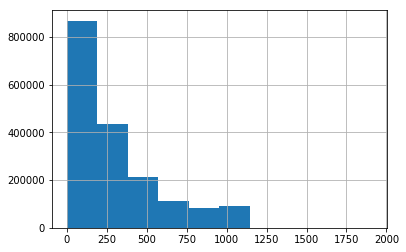

In [39]:
lens.hist();

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [40]:
label_cols = ['toxic', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,id,toxic,severe_toxicity,obscene,threat,insult,identity_attack,none
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,8.200849e-02,9.972995e-06,5.651918e-03,2.496573e-03,6.108460e-02,7.829909e-03,9.159986e-01
std,2.445187e+06,2.743777e-01,3.157990e-03,7.496651e-02,4.990332e-02,2.394855e-01,8.813970e-02,2.773900e-01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,5.769854e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [41]:
len(train),len(test)

(1804874, 97320)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [42]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

### Building the model

TF-IDF Vectorizer is used to vectorise the comments

In [43]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=word_tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [44]:
trn_term_doc, test_term_doc

(<1804874x2304861 sparse matrix of type '<class 'numpy.float64'>'
 	with 170107570 stored elements in Compressed Sparse Row format>,
 <97320x2304861 sparse matrix of type '<class 'numpy.float64'>'
 	with 9124050 stored elements in Compressed Sparse Row format>)

In [50]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [51]:
x = trn_term_doc
test_x = test_term_doc

In [52]:
print(test_term_doc)

  (0, 2215173)	0.10006306272618043
  (0, 2212065)	0.05151512124954903
  (0, 2105952)	0.09996826803093134
  (0, 2105940)	0.06336574570502959
  (0, 1996994)	0.14831466813202215
  (0, 1983679)	0.13983321394374026
  (0, 1971172)	0.04160843146272801
  (0, 1798807)	0.1787242327120229
  (0, 1798727)	0.13399055560130785
  (0, 1716339)	0.19907968714630236
  (0, 1716332)	0.1263121417255389
  (0, 1599967)	0.2434632153655707
  (0, 1599775)	0.10649646500957297
  (0, 1506149)	0.17761794575083575
  (0, 1489429)	0.15217178170363835
  (0, 1489353)	0.126315536287002
  (0, 1477275)	0.08792959116969182
  (0, 1475035)	0.05775955002093855
  (0, 1454998)	0.10702980048215424
  (0, 1453821)	0.11963761528822553
  (0, 1433887)	0.05240820742605657
  (0, 1155529)	0.16509154857066993
  (0, 1155471)	0.14593373993520745
  (0, 1129089)	0.13363479822079352
  (0, 1128178)	0.032696420253560725
  :	:
  (97318, 84615)	0.09412734290309624
  (97318, 77325)	0.0912675136919613
  (97318, 62948)	0.02586068672312247
  (97318, 421

Fit a model for one dependent at a time:

In [53]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [54]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    try:
        d = open(str(j) + '_model.p', 'wb')
        pickle.dump(m, d)
    finally:
        d.close()
    try:
        e = open(str(j) + '_r.p','wb')
        pickle.dump(r, e)
    finally:
        e.close()    

fit toxic


C:\Users\bhavy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bhavy\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit severe_toxicity
fit obscene
fit threat
fit insult
fit identity_attack


In [111]:
try:
    d = open('tf_idf_vectorizer.p', 'wb')
    pickle.dump(vec, d)
finally:
    d.close()

### Testing

In [57]:
import pickle
import numpy as np
import tweepy
import pandas as pd

vectorizer = pickle.load(open('tf_idf_vectorizer.p','rb'))

toxic_model = pickle.load(open('toxic_model.p','rb'))
toxic_r = pickle.load(open('toxic_r.p','rb'))

severe_toxicity_model = pickle.load(open('severe_toxicity_model.p','rb'))
severe_toxicity_r = pickle.load(open('severe_toxicity_r.p','rb'))

obscene_model = pickle.load(open('obscene_model.p','rb'))
obscene_r = pickle.load(open('obscene_r.p','rb'))

threat_model = pickle.load(open('threat_model.p','rb'))
threat_r = pickle.load(open('threat_r.p','rb'))

insult_model = pickle.load(open('insult_model.p','rb'))
insult_r = pickle.load(open('insult_r.p','rb'))

identity_attack_model = pickle.load(open('identity_attack_model.p','rb'))
identity_attack_r = pickle.load(open('identity_attack_r.p','rb'))

In [56]:
import os

try:
    d = open('tf_idf_vectorizer.p', 'wb')
    pickle.dump(vec, d)
finally:
    d.close()

In [58]:
label_cols = ['toxic', 'severe_toxicity', 'obscene', 'threat', 'insult','identity_attack']
models = {"toxic" : [toxic_model,toxic_r],"severe_toxicity" : [severe_toxicity_model,severe_toxicity_r],
            "obscene":[obscene_model,obscene_r],"threat":[threat_model,threat_r],"insult":[insult_model,insult_r],
            "identity_attack":[identity_attack_model,identity_attack_r]}

In [59]:
def get_model(name):
    return models[name]

In [63]:
text = ['hi how are you']
v = vectorizer.transform(text)
p = np.zeros((len(text), len(label_cols)))
for i, j in enumerate(label_cols):
    model = get_model(j)
    p[:,i] = model[0].predict_proba(v.multiply(model[1]))[:,1]
result = pd.concat([pd.DataFrame(p, columns = label_cols)], axis=1)

In [64]:
print(result)

      toxic  severe_toxicity   obscene    threat    insult  identity_attack
0  0.055231         0.000003  0.000994  0.000542  0.038848          0.00216
